# Description
The problem is a binary image classification problem. One needs to identify whether cancer tissue exists in small images. Each image is of size 96x96. There are 220025 images with ground truth labels that can be used for training. These training images are in the `train` folder and the ground truth labels of these training images are given in `train_labels.csv` file. A positive label means that cancer tissue exists in the center 32x32 patch of the corresponding image. There are also 57458 test images without ground truth labels in the `test` folder. These images are used for evaluation in the competetion.

In this project, I use PyTorch instead of keras because I am more familiar with PyTorch.

Development environment: Ubuntu 22.04, Python 3.10, PyTorch 2.1.0.

The GitHub repo is: https://github.com/spaceship-glitch/hcd

In [1]:
%matplotlib inline
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from matplotlib import pyplot as plt

# Exploratory Data Analysis

In [2]:
# The data are saved in the hcd folder
data_dir = Path('./hcd')
train_data_dir = data_dir / 'train'
train_label_csv = data_dir / 'train_labels.csv'

In [3]:
# helper functions
def get_img_file(img_id):
    return train_data_dir / (img_id + '.tif')

def get_class(class_name):
    return getattr(sys.modules[__name__], class_name)

In [4]:
# basic info of data in train_labels.csc
df = pd.read_csv(train_label_csv)
print("df shape: {}".format(df.shape))

df shape: (220025, 2)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [6]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [7]:
df.describe(include='all')

,id,label
count,220025,220025.000000
unique,220025,NaN
top,a81f84895ddcd522302ddf34be02eb1b3e5af1cb,NaN
freq,1,NaN
mean,NaN,0.405031
std,NaN,0.490899
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


array([[<Axes: title={'center': 'label'}>]], dtype=object)

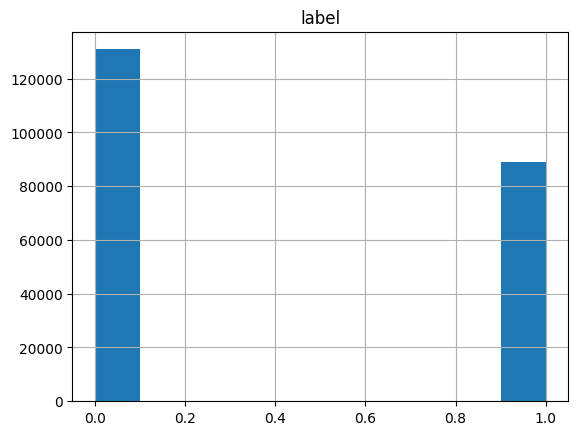

In [8]:
df.hist(column='label')

In [9]:
# check if invalid data exists in csv
check_for_nan = df.isnull().values.any()
print("NaN exists: {}".format(check_for_nan))

NaN exists: False


In [10]:
# check if each entry in csv has a correpsonding image in train folder
invalid_entries = []
for img_id in df['id']:
    img_file = get_img_file(img_id)
    if not img_file.is_file():
        invalid_entries.append(img_id)
print('#invalid entries: {}'.format(len(invalid_entries)))

#invalid entries: 0


image size: (96, 96, 3)


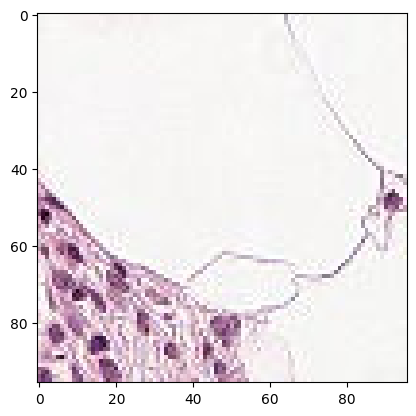

In [11]:
# show a sample image
img_sample = plt.imread(get_img_file(df['id'][0]))
print('image size: {}'.format(img_sample.shape))
plt.imshow(img_sample)
plt.show()

According to the above EDA, we can see that the training dataset is clean since there are no invalid entries. Because this is a binary image classification problem, I decide to use the CNN architecture. From the histogram of labels, we can see that the label values are 0s and 1s, so it is appropriate to use Sigmoid as the activation function in the output layer.

# Model Architecture
The CNN architecture is most suitable for a classification problem of images because of its computation efficiency, translation invariance and robustness. In each convolution layer, the image dimension is decreased and channel number is increased to condense the information of features in images. The ReLU activation function is very efficient, so I use it after each convolution layer. Each ReLU activation function is followed by a max-pool layer. After N blocks of `Convolution Layer + ReLU + Max Pool Layer`, the dimention should be 1x1. Then fully-connected layers are used as a final layer to convert a C-channel feature into a 1-channel feature. At last, the Sigmoid activation function is used to convert the 1-channel feature into a value between (0, 1) indicating the probability of the input image containing cancer tissue. There are many hyper-parameters in the architecture: the number of blocks N, the kernel size, stride, padding and output number of channels of each convolution layer, the kernel size of each max-pool layer, and the number of fully-connected layers after the convolution blocks, and so on. These hyper-parameters needs to be tuned.

# Training, Results and Analysis
Besides the hyper-parameters in the CNN architecture, there are also some hyper-parameters for training, including learning rate, optimization method, number of epochs, loss function and so on. First I try a combination of them based on experience. 

Adam mimics momentum for gradient and gradient-squared and is a popular optimization algorithm used for CNN, so I choose to use it in training processes. Since the output of a model should be a probability, I use the Binary Cross Entropy Loss. I also use the visulization toolkit TensorBoard to monitor training processes. After the completion of training, I plot a figure of Training and Validation Loss to show the performance of training, and if it is acceptible, I plot the ROC curve and compute the AUC score to show the performance of the model on a test dataset.

In [12]:
# read image data
# B x H x W x C
imgs = []
for img_id in df['id']:
    img_file = get_img_file(img_id)
    imgs.append(plt.imread(img_file))
imgs = np.array(imgs)
print(imgs.shape)
b, h, w, c = imgs.shape

(220025, 96, 96, 3)


In [13]:
# split data into train/validation/test: dataset size 0.9:0.05:0.05
X_train, X_val_test, y_train, y_val_test = train_test_split(imgs, df['label'], train_size=0.9)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, train_size=0.5)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)
train_size = len(X_train)

print("X_train shape： {}, y_train shape: {}".format(X_train.shape, y_train.shape))
print("X_val shape： {}, y_val shape: {}".format(X_val.shape, y_val.shape))
print("X_test shape： {}, y_test shape: {}".format(X_test.shape, y_test.shape))

X_train shape： (198022, 96, 96, 3), y_train shape: (198022,)
X_val shape： (11001, 96, 96, 3), y_val shape: (11001,)
X_test shape： (11002, 96, 96, 3), y_test shape: (11002,)


In [12]:
class CNNModel1(nn.Module):
    def __init__(self, conv_config_items):
        super(CNNModel1, self).__init__()

        # n * (convolution layer + ReLU activation + max pool layer)
        convs = []
        for config_item in conv_config_items:
            convs.append(nn.Sequential(
                nn.Conv2d(
                    in_channels = config_item['in_channels'],
                    out_channels = config_item['out_channels'],
                    kernel_size = config_item['kernel_size'],
                    stride = config_item['stride'],
                    padding = config_item['padding']
                ),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = config_item['pool_kernel_size'])
            ))
        self.convs = nn.ModuleList(convs)

        # Fully-connected layer
        self.linear1 = nn.Linear(
            in_features = conv_config_items[-1]['out_channels'],
            out_features = 1
        )
        # output range (0, 1)
        self.sigmoid = nn.Sigmoid()

    # input shape: B x C x H x W
    # output shape: B
    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        b, c, h, w = x.shape
        # h and w should be 1
        x = x.reshape(b, c)
        x = self.linear1(x)
        x = self.sigmoid(x)
        x = x.reshape(b)
        return x
        

In [15]:
def train(cnn_model_class_name, cnn_config, lr, num_epochs, batch_size, ckpt_fn):
    cnn_model_class = get_class(cnn_model_class_name)
    cnn = cnn_model_class(cnn_config)
    cnn.cuda()
    batch_num = int(np.ceil(train_size / batch_size))

    # Adam optimizer
    optimizer = torch.optim.Adam(cnn.parameters(), lr = lr)
    # binary cross entropy loss
    loss_fn = torch.nn.BCELoss()

    losses_train = []
    losses_val_test = []

    writer = SummaryWriter()
    
    for epoch in range(num_epochs):
        with torch.no_grad():
            cnn.eval()

            X_val_test_cuda = torch.from_numpy(X_val).to(torch.float).cuda() / 255.0
            y_val_test_cuda = torch.from_numpy(y_val).to(torch.float).cuda()
            # shape: B x C x H x W
            X_val_test_cuda = X_val_test_cuda.permute(0, 3, 1, 2)
            
            pred_y_val_test = cnn(X_val_test_cuda)
            loss_val_test = loss_fn(pred_y_val_test, y_val_test_cuda)
            losses_val_test.append(loss_val_test.item())
            # delete validation/test tensors from gpu
            del X_val_test_cuda
            del y_val_test_cuda
            del pred_y_val_test
            
        loss_epoch = 0
        # shuffle train data in every epoch
        X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train)
        cnn.train()
        for i in range(batch_num):
            if i == batch_num - 1:
                x = X_train_shuffle[i * batch_size:]
                y = y_train_shuffle[i * batch_size:]
            else:
                x = X_train_shuffle[i * batch_size : (i + 1) * batch_size]
                y = y_train_shuffle[i * batch_size : (i + 1) * batch_size]

            x = torch.from_numpy(x).to(torch.float).cuda() / 255.0
            # B x C x H x W
            x = x.permute(0, 3, 1, 2)
            y = torch.from_numpy(y).to(torch.float).cuda()

            optimizer.zero_grad()
            y_pred = cnn(x)
            loss = loss_fn(y_pred, y)
            loss_epoch += loss.item()
            loss.backward()
            optimizer.step()

            del x
            del y
            del y_pred

        losses_train.append(loss_epoch / batch_num)

        writer.add_scalar("Loss/train", losses_train[-1], epoch)
        writer.add_scalar("Loss/val", losses_val_test[-1], epoch)

    writer.close()

    cnn.cpu()
    torch.save({
        'epoch': num_epochs,
        'model_name': cnn_model_class_name,
        'cnn_config': cnn_config,
        'model_state_dict': cnn.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses_train': losses_train,
        'losses_val': losses_val_test
    }, ckpt_fn)

    del cnn
    del optimizer


In [16]:
def plot_loss(ckpt_fn):
    ckpt_dict = torch.load(ckpt_fn)
    num_epochs = ckpt_dict['epoch']
    losses_train = ckpt_dict['losses_train']
    losses_val_test = ckpt_dict['losses_val']
    
    plt.figure()
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('BCE Loss')
    labels_epoch = np.arange(num_epochs)
    plt.plot(labels_epoch, losses_train, label='train')
    plt.plot(labels_epoch, losses_val_test, label='validation')
    plt.legend()
    plt.show()

In [17]:
def plot_roc_auc(ckpt_fn):
    ckpt_dict = torch.load(ckpt_fn)
    cnn_model_class = get_class(ckpt_dict['model_name'])
    cnn = cnn_model_class(ckpt_dict['cnn_config'])
    cnn.load_state_dict(ckpt_dict['model_state_dict'])
    cnn.cuda()
    
    with torch.no_grad():
        cnn.eval()
        # test performance of model
        X_val_test_cuda = torch.from_numpy(X_test).to(torch.float).cuda() / 255.0
        # shape: B x C x H x W
        X_val_test_cuda = X_val_test_cuda.permute(0, 3, 1, 2)
        pred_y_val_test = cnn(X_val_test_cuda)
        pred_y_val_test = pred_y_val_test.cpu()
        fpr, tpr, thresholds = roc_curve(y_test, pred_y_val_test)
        auc_score = auc(fpr, tpr)
        plt.figure()
        plt.title("ROC curve, AUC={:.3f}".format(auc_score))
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.plot(fpr, tpr)
        plt.show()

## Trial 1
In the CNN archetecture of Trial 1, there are 5 blocks of `Convolution Layer + ReLU + Max Pool Layer`. In each convolution layer, the kernel size is 3, stride is 1 and padding is 0. The number of output channels is doubled compared to the number of input channels in each convolution layer. And the kernel size of each max-pool layer is 2. I train the model with a learning rate of 1e-4 for 300 epochs.

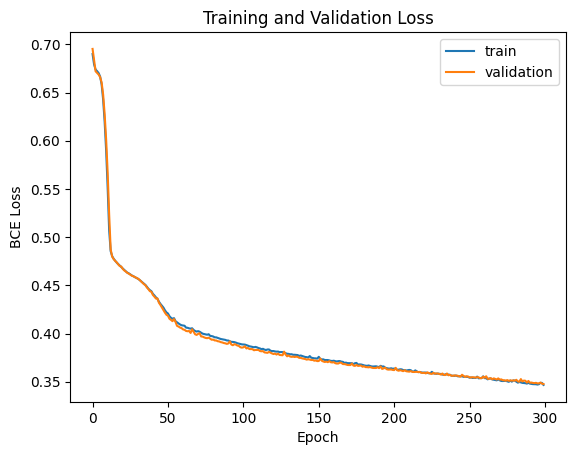

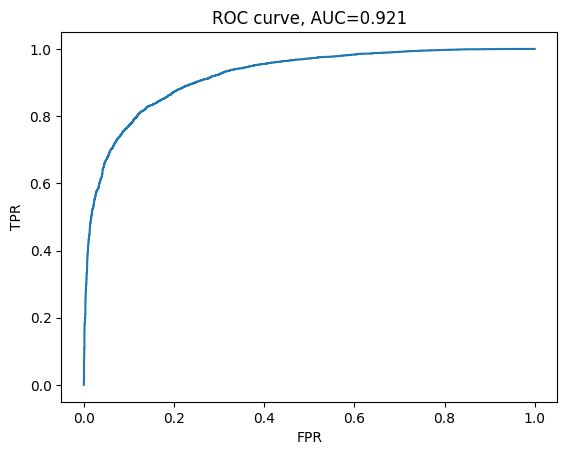

In [20]:
# trial 1
cnn_model_class = 'CNNModel1'
cnn_config = [
    # shape: B x 3 x 96 x 96 => B x 6 x 47 x 47
    {
        'in_channels':3,
        'out_channels':6,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    },
    # shape: B x 6 x 47 x 47 => B x 12 x 22 x 22
    {
        'in_channels':6,
        'out_channels':12,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    },
    # shape: B x 12 x 22 x 22 => B x 24 x 10 x 10
    {
        'in_channels':12,
        'out_channels':24,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    },
    # shape: B x 24 x 10 x 10 => B x 48 x 4 x 4
    {
        'in_channels':24,
        'out_channels':48,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    },
    # shape: B x 48 x 4 x 4 => B x 96 x 1 x 1
    {
        'in_channels':48,
        'out_channels':96,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    }
]
lr = 1e-4
num_epochs = 300
batch_size = 10000
train(cnn_model_class, cnn_config, lr, num_epochs, batch_size, 'model_a.ckpt')
plot_loss('model_a.ckpt')
plot_roc_auc('model_a.ckpt')

#### Result of Trial 1
According to the figure of Train and Validation Loss, the trained model shows little overfitting. The second figure shows the AUC score on the test dataset is 0.921. I think it is an acceptible result. However, in the first figure the loss is still decreasing and I suspect that the training process has not converged. To improve the performance, I can increase the learning rate or increase the number of epochs.

## Trial 2
The model architecture in Trial 2 is the same as that in Trial 1. I choose to increase the learning rate because a larger number of epochs means longer training time. I train the model with a learning rate of 5e-3 for 300 epochs.

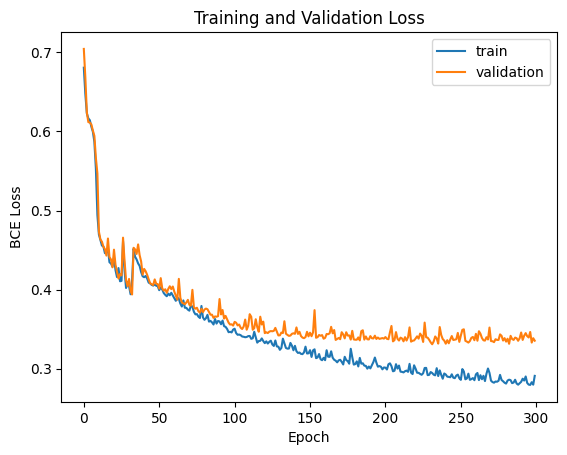

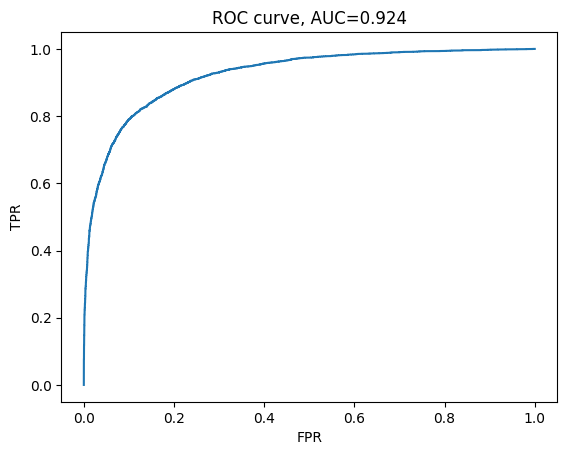

In [21]:
# trial 2
cnn_model_class = 'CNNModel1'
cnn_config = [
    # shape: B x 3 x 96 x 96 => B x 6 x 47 x 47
    {
        'in_channels':3,
        'out_channels':6,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    },
    # shape: B x 6 x 47 x 47 => B x 12 x 22 x 22
    {
        'in_channels':6,
        'out_channels':12,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    },
    # shape: B x 12 x 22 x 22 => B x 24 x 10 x 10
    {
        'in_channels':12,
        'out_channels':24,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    },
    # shape: B x 24 x 10 x 10 => B x 48 x 4 x 4
    {
        'in_channels':24,
        'out_channels':48,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    },
    # shape: B x 48 x 4 x 4 => B x 96 x 1 x 1
    {
        'in_channels':48,
        'out_channels':96,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    }
]
lr = 5e-3
num_epochs = 300
batch_size = 10000
train(cnn_model_class, cnn_config, lr, num_epochs, batch_size, 'model_b.ckpt')
plot_loss('model_b.ckpt')
plot_roc_auc('model_b.ckpt')

#### Result of Trial 2
According to the figure of Traning and Validation Loss, with the learning rate of 5e-3, the training process converges after 200 epochs. And the model shows a little overfitting after 150 epochs. The AUC score on the test dataset is 0.924 which is almost the same as that of Trial 1. 

## Trial 3
Next, I add a learning rate scheduler to the training process to see whether the performance can be improved. I use an initial learning rate of 5e-3 and decays the learning rate by a factor of 0.99 every epoch.

In [20]:
# difference of train2 from train: adding an exponential learning rate scheduler
def train2(cnn_model_class_name, cnn_config, lr, num_epochs, batch_size, exp_lr_gamma, ckpt_fn):
    cnn_model_class = get_class(cnn_model_class_name)
    cnn = cnn_model_class(cnn_config)
    cnn.cuda()
    batch_num = int(np.ceil(train_size / batch_size))

    # Adam optimizer
    optimizer = torch.optim.Adam(cnn.parameters(), lr = lr)
    # exponential lr scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=exp_lr_gamma)
    
    # binary cross entropy loss
    loss_fn = torch.nn.BCELoss()

    losses_train = []
    losses_val_test = []

    writer = SummaryWriter()
    
    for epoch in range(num_epochs):
        with torch.no_grad():
            cnn.eval()

            X_val_test_cuda = torch.from_numpy(X_val).to(torch.float).cuda() / 255.0
            y_val_test_cuda = torch.from_numpy(y_val).to(torch.float).cuda()
            # shape: B x C x H x W
            X_val_test_cuda = X_val_test_cuda.permute(0, 3, 1, 2)
            
            pred_y_val_test = cnn(X_val_test_cuda)
            loss_val_test = loss_fn(pred_y_val_test, y_val_test_cuda)
            losses_val_test.append(loss_val_test.item())
            # delete validation/test tensors from gpu
            del X_val_test_cuda
            del y_val_test_cuda
            del pred_y_val_test
            
        loss_epoch = 0
        # shuffle train data in every epoch
        X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train)
        cnn.train()
        for i in range(batch_num):
            if i == batch_num - 1:
                x = X_train_shuffle[i * batch_size:]
                y = y_train_shuffle[i * batch_size:]
            else:
                x = X_train_shuffle[i * batch_size : (i + 1) * batch_size]
                y = y_train_shuffle[i * batch_size : (i + 1) * batch_size]

            x = torch.from_numpy(x).to(torch.float).cuda() / 255.0
            # B x C x H x W
            x = x.permute(0, 3, 1, 2)
            y = torch.from_numpy(y).to(torch.float).cuda()

            optimizer.zero_grad()
            y_pred = cnn(x)
            loss = loss_fn(y_pred, y)
            loss_epoch += loss.item()
            loss.backward()
            optimizer.step()

            del x
            del y
            del y_pred

        scheduler.step()

        losses_train.append(loss_epoch / batch_num)

        writer.add_scalar("Loss/train", losses_train[-1], epoch)
        writer.add_scalar("Loss/val", losses_val_test[-1], epoch)

    writer.close()

    torch.save({
        'epoch': num_epochs,
        'model_name': cnn_model_class_name,
        'cnn_config': cnn_config,
        'model_state_dict': cnn.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses_train': losses_train,
        'losses_val': losses_val_test
    }, ckpt_fn)

    del cnn
    del optimizer
    

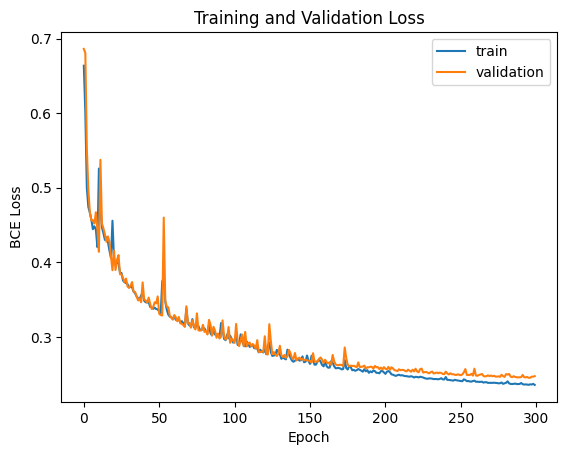

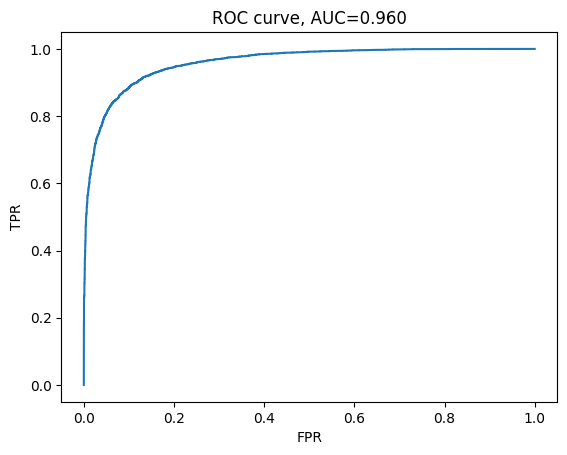

In [25]:
# trial 3
cnn_model_class = 'CNNModel1'
cnn_config = [
    # shape: B x 3 x 96 x 96 => B x 6 x 47 x 47
    {
        'in_channels':3,
        'out_channels':6,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    },
    # shape: B x 6 x 47 x 47 => B x 12 x 22 x 22
    {
        'in_channels':6,
        'out_channels':12,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    },
    # shape: B x 12 x 22 x 22 => B x 24 x 10 x 10
    {
        'in_channels':12,
        'out_channels':24,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    },
    # shape: B x 24 x 10 x 10 => B x 48 x 4 x 4
    {
        'in_channels':24,
        'out_channels':48,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    },
    # shape: B x 48 x 4 x 4 => B x 96 x 1 x 1
    {
        'in_channels':48,
        'out_channels':96,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    }
]
lr = 5e-3
num_epochs = 300
batch_size = 10000
exp_lr_gamma = 0.99
train2(cnn_model_class, cnn_config, lr, num_epochs, batch_size, exp_lr_gamma, 'model_c.ckpt')
plot_loss('model_c.ckpt')
plot_roc_auc('model_c.ckpt')

#### Result of Trial 3
After adding an exponential scheduler, the perofrmance is better. It converges well and shows little overfitting in the figure of Training and Validation Loss. And the AUC score on the test dataset is improved (0.960).

## Trial 4
Next, I try larger convolution kernel sizes.

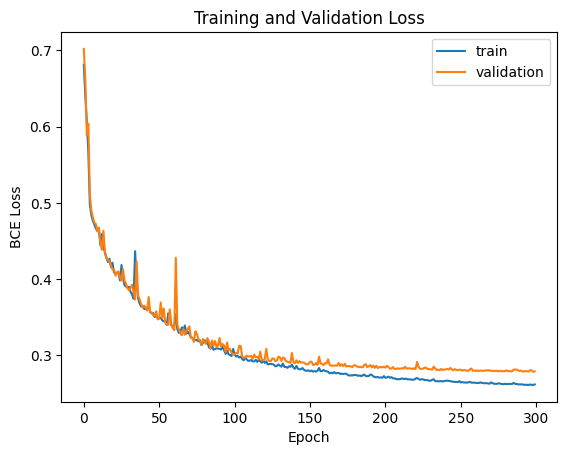

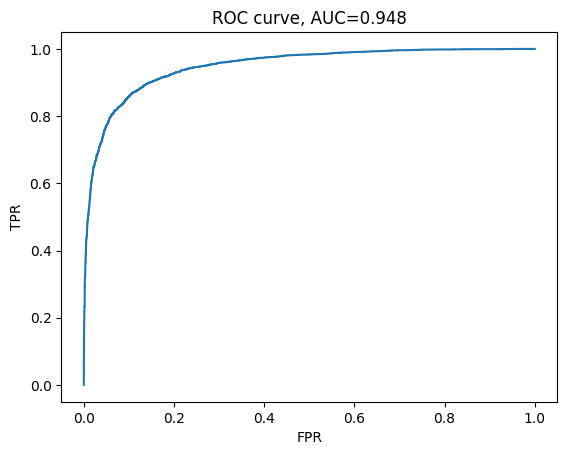

In [28]:
# trial 4, larger kernel sizes in the first 3 convolution layers
cnn_model_class = 'CNNModel1'
cnn_config = [
    # shape: B x 3 x 96 x 96 => B x 6 x 46 x 46
    {
        'in_channels':3,
        'out_channels':6,
        'kernel_size':5,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    },
    # shape: B x 6 x 46 x 46 => B x 12 x 21 x 21
    {
        'in_channels':6,
        'out_channels':12,
        'kernel_size':5,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    },
    # shape: B x 12 x 21 x 21 => B x 24 x 8 x 8
    {
        'in_channels':12,
        'out_channels':24,
        'kernel_size':5,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    },
    # shape: B x 24 x 8 x 8 => B x 48 x 3 x 3
    {
        'in_channels':24,
        'out_channels':48,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    },
    # shape: B x 48 x 3 x 3 => B x 96 x 1 x 1
    {
        'in_channels':48,
        'out_channels':96,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':1
    }
]
lr = 5e-3
num_epochs = 300
batch_size = 10000
exp_lr_gamma = 0.99
train2(cnn_model_class, cnn_config, lr, num_epochs, batch_size, exp_lr_gamma, 'model_d.ckpt')
plot_loss('model_d.ckpt')
plot_roc_auc('model_d.ckpt')

#### Result of Trial 4
After changing the kernel size of the first three convolution layers from 3 to 5, the BCE loss and AUC score both get worse than those in Trial 3. Maybe the training hyper-parameters suitable for Trial 3 are not suitable for Trial 4.

## Trial 5
In this trial, I try a more complex CNN architecture to further improve the performance. In this architecture, there are two convolution layers in each block: `Convolution Layer 1 + ReLU + Convolution Layer 2 + ReLU + Max Pool Layer`. For the training process, I use the same training hyper-parameters as those in Trial 3 except the batch size. Because of limitation of GPU memory size, the batch size is smaller than that in the previous trials.

In [19]:
# two convolution layers in each block
class CNNModel2(nn.Module):
    def __init__(self, conv_config_items):
        super(CNNModel2, self).__init__()

        # n * (convolution layer 1 + ReLU + convolution layer 2 + ReLU + max pool layer)
        convs = []
        for config_item in conv_config_items:
            convs.append(nn.Sequential(
                nn.Conv2d(
                    in_channels = config_item['in_channels'],
                    out_channels = config_item['inter_channels'],
                    kernel_size = config_item['kernel_size1'],
                    stride = config_item['stride1'],
                    padding = config_item['padding1']
                ),
                nn.ReLU(),
                nn.Conv2d(
                    in_channels = config_item['inter_channels'],
                    out_channels = config_item['out_channels'],
                    kernel_size = config_item['kernel_size2'],
                    stride = config_item['stride2'],
                    padding = config_item['padding2']
                ),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = config_item['pool_kernel_size'])
            ))
        self.convs = nn.ModuleList(convs)

        # Fully-connected layer
        self.linear1 = nn.Linear(
            in_features = conv_config_items[-1]['out_channels'],
            out_features = 1
        )
        # output range (0, 1)
        self.sigmoid = nn.Sigmoid()

    # input shape: B x C x H x W
    # output shape: B
    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        b, c, h, w = x.shape
        # h and w should be 1
        x = x.reshape(b, c)
        x = self.linear1(x)
        x = self.sigmoid(x)
        x = x.reshape(b)
        return x
        

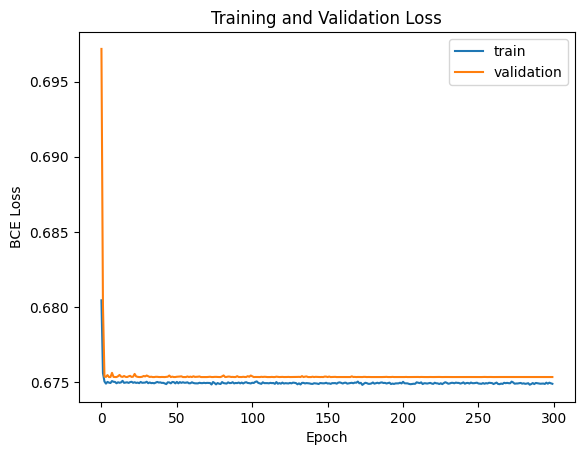

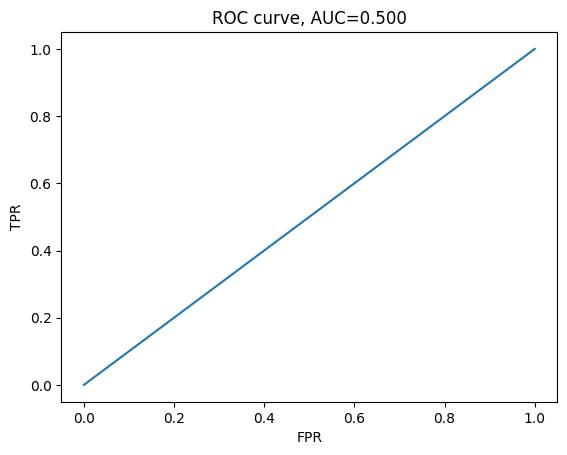

In [20]:
# trial 5, two convolution layers in each block
cnn_model_class = 'CNNModel2'
cnn_config = [
    # shape: B x 3 x 96 x 96 => B x 6 x 47 x 47
    {
        'in_channels':3,
        'inter_channels': 6,
        'out_channels':6,
        'kernel_size1':3,
        'stride1':1,
        'padding1':0,
        'kernel_size2':3,
        'stride2':1,
        'padding2':1,
        'pool_kernel_size':2
    },
    # shape: B x 6 x 47 x 47 => B x 12 x 22 x 22
    {
        'in_channels':6,
        'inter_channels': 12,
        'out_channels':12,
        'kernel_size1':3,
        'stride1':1,
        'padding1':0,
        'kernel_size2':3,
        'stride2':1,
        'padding2':1,
        'pool_kernel_size':2
    },
    # shape: B x 12 x 22 x 22 => B x 24 x 10 x 10
    {
        'in_channels':12,
        'inter_channels': 24,
        'out_channels':24,
        'kernel_size1':3,
        'stride1':1,
        'padding1':0,
        'kernel_size2':3,
        'stride2':1,
        'padding2':1,
        'pool_kernel_size':2
    },
    # shape: B x 24 x 10 x 10 => B x 48 x 4 x 4
    {
        'in_channels':24,
        'inter_channels': 48,
        'out_channels':48,
        'kernel_size1':3,
        'stride1':1,
        'padding1':0,
        'kernel_size2':3,
        'stride2':1,
        'padding2':1,
        'pool_kernel_size':2
    },
    # shape: B x 48 x 4 x 4 => B x 96 x 1 x 1
    {
        'in_channels':48,
        'inter_channels': 96,
        'out_channels':96,
        'kernel_size1':3,
        'stride1':1,
        'padding1':0,
        'kernel_size2':3,
        'stride2':1,
        'padding2':1,
        'pool_kernel_size':2
    }
]
lr = 5e-3
num_epochs = 300
batch_size = 5000
exp_lr_gamma = 0.99
train2(cnn_model_class, cnn_config, lr, num_epochs, batch_size, exp_lr_gamma, 'model_e.ckpt')
plot_loss('model_e.ckpt')
plot_roc_auc('model_e.ckpt')

#### Result of Trial 5
It shows a very bad result. The training process does not converge.

## Trial 6
Now I try adding Batch Normalization Layers into CNNModel2.

In [21]:
# adding BatchNorm layers
class CNNModel3(nn.Module):
    def __init__(self, conv_config_items):
        super(CNNModel3, self).__init__()

        # n * (convolution layer 1 + ReLU + Batch Normalization + convolution layer 2 + ReLU + Batch Normalization + max pool layer)
        convs = []
        for config_item in conv_config_items:
            convs.append(nn.Sequential(
                nn.Conv2d(
                    in_channels = config_item['in_channels'],
                    out_channels = config_item['inter_channels'],
                    kernel_size = config_item['kernel_size1'],
                    stride = config_item['stride1'],
                    padding = config_item['padding1']
                ),
                nn.ReLU(),
                nn.BatchNorm2d(config_item['inter_channels']),
                nn.Conv2d(
                    in_channels = config_item['inter_channels'],
                    out_channels = config_item['out_channels'],
                    kernel_size = config_item['kernel_size2'],
                    stride = config_item['stride2'],
                    padding = config_item['padding2']
                ),
                nn.ReLU(),
                nn.BatchNorm2d(config_item['out_channels']),
                nn.MaxPool2d(kernel_size = config_item['pool_kernel_size'])
            ))
        self.convs = nn.ModuleList(convs)

        # Fully-connected layer
        self.linear1 = nn.Linear(
            in_features = conv_config_items[-1]['out_channels'],
            out_features = 1
        )
        # output range (0, 1)
        self.sigmoid = nn.Sigmoid()

    # input shape: B x C x H x W
    # output shape: B
    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        b, c, h, w = x.shape
        # h and w should be 1
        x = x.reshape(b, c)
        x = self.linear1(x)
        x = self.sigmoid(x)
        x = x.reshape(b)
        return x
        

In [ ]:
# trial 6
cnn_model_class = 'CNNModel3'
cnn_config = [
    # shape: B x 3 x 96 x 96 => B x 6 x 47 x 47
    {
        'in_channels':3,
        'inter_channels': 6,
        'out_channels':6,
        'kernel_size1':3,
        'stride1':1,
        'padding1':0,
        'kernel_size2':3,
        'stride2':1,
        'padding2':1,
        'pool_kernel_size':2
    },
    # shape: B x 6 x 47 x 47 => B x 12 x 22 x 22
    {
        'in_channels':6,
        'inter_channels': 12,
        'out_channels':12,
        'kernel_size1':3,
        'stride1':1,
        'padding1':0,
        'kernel_size2':3,
        'stride2':1,
        'padding2':1,
        'pool_kernel_size':2
    },
    # shape: B x 12 x 22 x 22 => B x 24 x 10 x 10
    {
        'in_channels':12,
        'inter_channels': 24,
        'out_channels':24,
        'kernel_size1':3,
        'stride1':1,
        'padding1':0,
        'kernel_size2':3,
        'stride2':1,
        'padding2':1,
        'pool_kernel_size':2
    },
    # shape: B x 24 x 10 x 10 => B x 48 x 4 x 4
    {
        'in_channels':24,
        'inter_channels': 48,
        'out_channels':48,
        'kernel_size1':3,
        'stride1':1,
        'padding1':0,
        'kernel_size2':3,
        'stride2':1,
        'padding2':1,
        'pool_kernel_size':2
    },
    # shape: B x 48 x 4 x 4 => B x 96 x 1 x 1
    {
        'in_channels':48,
        'inter_channels': 96,
        'out_channels':96,
        'kernel_size1':3,
        'stride1':1,
        'padding1':0,
        'kernel_size2':3,
        'stride2':1,
        'padding2':1,
        'pool_kernel_size':2
    }
]
lr = 5e-3
num_epochs = 300
batch_size = 5000
exp_lr_gamma = 0.99
train2(cnn_model_class, cnn_config, lr, num_epochs, batch_size, exp_lr_gamma, 'model_f.ckpt')

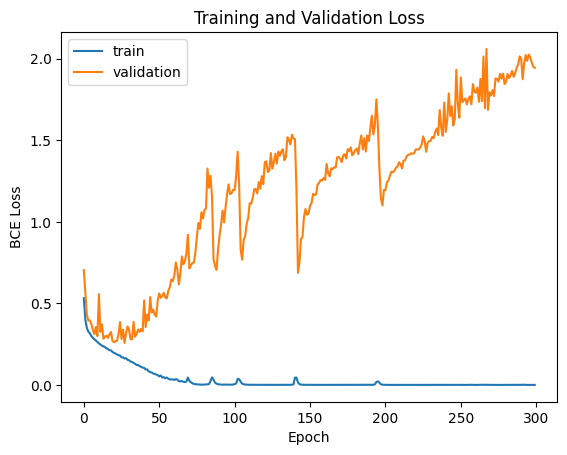

In [24]:
plot_loss('model_f.ckpt')

#### Result of Trial 6
The training process converges faster. However, the result shows severe overfitting. The model is too complex and I need a simpler model.

## Trial 7
To make the model simpler, I decrease the number of intermediate channels (inter_channels in cnn_config) in this trial. The number of epochs is also decreased since it shows faster convergence with Batch Normalization Layers in Trial 6.

In [ ]:
# trial 7
cnn_model_class = 'CNNModel3'
cnn_config = [
    # shape: B x 3 x 96 x 96 => B x 6 x 47 x 47
    {
        'in_channels':3,
        'inter_channels': 3,
        'out_channels':6,
        'kernel_size1':3,
        'stride1':1,
        'padding1':0,
        'kernel_size2':3,
        'stride2':1,
        'padding2':1,
        'pool_kernel_size':2
    },
    # shape: B x 6 x 47 x 47 => B x 12 x 22 x 22
    {
        'in_channels':6,
        'inter_channels': 6,
        'out_channels':12,
        'kernel_size1':3,
        'stride1':1,
        'padding1':0,
        'kernel_size2':3,
        'stride2':1,
        'padding2':1,
        'pool_kernel_size':2
    },
    # shape: B x 12 x 22 x 22 => B x 24 x 10 x 10
    {
        'in_channels':12,
        'inter_channels': 12,
        'out_channels':24,
        'kernel_size1':3,
        'stride1':1,
        'padding1':0,
        'kernel_size2':3,
        'stride2':1,
        'padding2':1,
        'pool_kernel_size':2
    },
    # shape: B x 24 x 10 x 10 => B x 48 x 4 x 4
    {
        'in_channels':24,
        'inter_channels': 24,
        'out_channels':48,
        'kernel_size1':3,
        'stride1':1,
        'padding1':0,
        'kernel_size2':3,
        'stride2':1,
        'padding2':1,
        'pool_kernel_size':2
    },
    # shape: B x 48 x 4 x 4 => B x 96 x 1 x 1
    {
        'in_channels':48,
        'inter_channels': 48,
        'out_channels':96,
        'kernel_size1':3,
        'stride1':1,
        'padding1':0,
        'kernel_size2':3,
        'stride2':1,
        'padding2':1,
        'pool_kernel_size':2
    }
]
lr = 5e-3
num_epochs = 150
batch_size = 5000
exp_lr_gamma = 0.99
train2(cnn_model_class, cnn_config, lr, num_epochs, batch_size, exp_lr_gamma, 'model_g.ckpt')

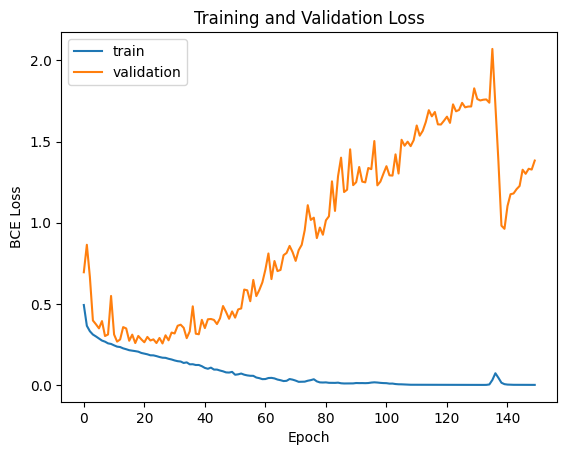

In [25]:
plot_loss('model_g.ckpt')

#### Result of Trial 7
The result is still very bad. The result shows severe overfitting.

## Trial 8
In Trial 3, the model is simple and the performance is best. In this trial, Batch Normalization Layers are added to increase the convergence speed.

In [21]:
# adding BatchNorm layer into CNNModel1
class CNNModel4(nn.Module):
    def __init__(self, conv_config_items):
        super(CNNModel4, self).__init__()

        # n * (convolution layer + ReLU activation + max pool layer)
        convs = []
        for config_item in conv_config_items:
            convs.append(nn.Sequential(
                nn.Conv2d(
                    in_channels = config_item['in_channels'],
                    out_channels = config_item['out_channels'],
                    kernel_size = config_item['kernel_size'],
                    stride = config_item['stride'],
                    padding = config_item['padding']
                ),
                nn.ReLU(),
                nn.BatchNorm2d(config_item['out_channels']),
                nn.MaxPool2d(kernel_size = config_item['pool_kernel_size'])
            ))
        self.convs = nn.ModuleList(convs)

        # Fully-connected layer
        self.linear1 = nn.Linear(
            in_features = conv_config_items[-1]['out_channels'],
            out_features = 1
        )
        # output range (0, 1)
        self.sigmoid = nn.Sigmoid()

    # input shape: B x C x H x W
    # output shape: B
    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        b, c, h, w = x.shape
        # h and w should be 1
        x = x.reshape(b, c)
        x = self.linear1(x)
        x = self.sigmoid(x)
        x = x.reshape(b)
        return x
        

In [23]:
# trial 8
cnn_model_class = 'CNNModel4'
cnn_config = [
    # shape: B x 3 x 96 x 96 => B x 6 x 47 x 47
    {
        'in_channels':3,
        'out_channels':6,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    },
    # shape: B x 6 x 47 x 47 => B x 12 x 22 x 22
    {
        'in_channels':6,
        'out_channels':12,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    },
    # shape: B x 12 x 22 x 22 => B x 24 x 10 x 10
    {
        'in_channels':12,
        'out_channels':24,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    },
    # shape: B x 24 x 10 x 10 => B x 48 x 4 x 4
    {
        'in_channels':24,
        'out_channels':48,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    },
    # shape: B x 48 x 4 x 4 => B x 96 x 1 x 1
    {
        'in_channels':48,
        'out_channels':96,
        'kernel_size':3,
        'stride':1,
        'padding':0,
        'pool_kernel_size':2
    }
]
lr = 5e-3
num_epochs = 150
batch_size = 5000
exp_lr_gamma = 0.99
train2(cnn_model_class, cnn_config, lr, num_epochs, batch_size, exp_lr_gamma, 'model_h.ckpt')

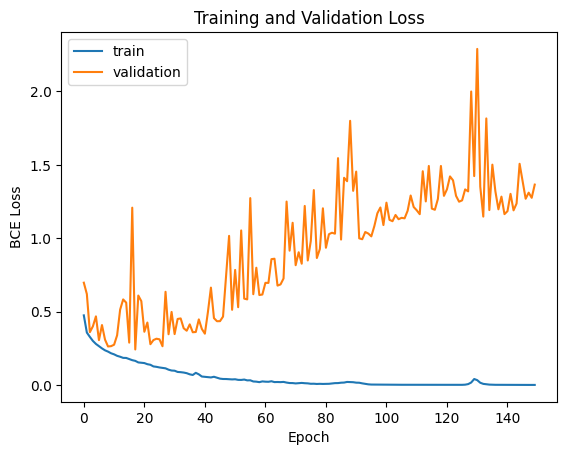

In [24]:
plot_loss('model_h.ckpt')

#### Result of Trial 8
The addition of Batch Normalization Layers destroys the performance of the model. Currently I do not know why this happens and I need more time to investigate this.

## Summary of Trials
In Trial 1, there are 5 blocks of `Convolution Layer + ReLU + Max Pool Layer`. In each convolution layer, the kernel size is 3, stride is 1 and padding is 0. The number of output channels is doubled compared to the number of input channels in each convolution layer. And the kernel size of each max-pool layer is 2. I train the model with a learning rate of 1e-4 for 300 epochs. The result shows little overfitting. However, it seems that the training process has not converged after 300 epochs. Then in Trial 2, I increase the learning rate to 5e-3 and the result converges and shows a little overfitting. Then in Trial 3, I add a learning rate scheduler to gradually decrease the learning rate during training and it shows convergence and little overfitting. The performance is good and I want to improve it further, so I perform the following trials. In Trial 4, I increase the convolution kernel sizes and get a worse result than Trial 3. In Trial 5, I use a more complex CNN architecture, where each block is `Convolution Layer 1 + ReLU + Convolution Layer 2 + ReLU + Max Pool Layer`. The training process does not converge. In Trial 6, I add Batch Normalization Layers into the model of Trial 5, and each block becomes `Convolution Layer 1 + ReLU + Batch Normalization + Convolution Layer 2 + ReLU + Batch Normalization + Max Pool Layer`. The result shows fast convergence but severe overfitting. Batch Normalization Layers are also used in Trials 7 and 8, and the results of both these two trials show fast convergence and severe overfitting. It seems that Batch Normalization can accelerate the convergence speed but lead to overfitting.

A suitable learning rate and a learning rate scheduler help to improve training performance. A small learning rate leads to slow convergence and long training time. A large learning rate makes it hard to converge. So it is better to use a large initial learning rate and gradually decrease the learning rate when it approaches a local minimum.

It is said that with Batch Normalization one can avoid vanishing gradient and internal covariate shift and accelerate convergence. In my trials, Batch Normalization can accelerate convergence, however, it collapses the performance of the models. I do not know how to explain this phenomenon now and will spend some time investigating it.

When using more complex models, I do not get better results. Maybe the hyper-parameters need to be re-tuned for these models.

# Conclusion
In this project, I tried different CNN architectures and different hyper-parameters. The best model consists of 5 blocks `Convolution Layer + ReLU + Max Pool Layer`. In each convolution layer, the kernel size is 3, stride is 1 and padding is 0. The number of output channels is doubled compared to the number of input channels in each convolution layer. The model is trained for 300 epochs with an initial learning rate 5e-3 and the learning rate gradually decreases. The trained model gives an AUC score of 0.960 on the test dataset.

I also generate a submission result using the best model and submit it onto Kaggle. The public and private scores of the submission are 0.924 and 0.884, respetively.

The learnig rate, including the strategy of adjusting the learning rate, is essential for the training process. I also tried Batch Normalization, but it resulted in overfitting.

Since the current best model does not show overfitting, I believe that a slightly more complex model could improve the performance. However, it needs to re-tune the hyper-parameters and I have not obtained a better result with a more complex model yet. The future work is to tune the hyper-parameters with a more complex model.

In [15]:
# generating submission file
test_data_dir = data_dir / 'test'

def get_test_img_file(test_img_id):
    return test_data_dir / (test_img_id + '.tif')

def generate_submission_file(ckpt_fn, output_fn):
    test_img_ids = [p.stem for p in test_data_dir.iterdir()]
    test_imgs = []
    for test_img_id in test_img_ids:
        img_file = get_test_img_file(test_img_id)
        test_imgs.append(plt.imread(img_file))
    test_imgs = np.array(test_imgs)
    print(test_imgs.shape)

    ckpt_dict = torch.load(ckpt_fn)
    cnn_model_class = get_class(ckpt_dict['model_name'])
    cnn = cnn_model_class(ckpt_dict['cnn_config'])
    cnn.load_state_dict(ckpt_dict['model_state_dict'])
    cnn.cuda()

    with torch.no_grad():
        cnn.eval()

        pred_test = []
        
        num_test_imgs = test_imgs.shape[0]
        test_batch_size = 10000
        test_batch_num = int(np.ceil(num_test_imgs / test_batch_size))
        for i in range(test_batch_num):
            if i == test_batch_num - 1:
                test_imgs_batch = torch.from_numpy(test_imgs[test_batch_size * i:]).to(torch.float).cuda() / 255.0
            else:
                test_imgs_batch = torch.from_numpy(test_imgs[test_batch_size * i:test_batch_size * (i + 1)]).to(torch.float).cuda() / 255.0
            test_imgs_batch = test_imgs_batch.permute(0, 3, 1, 2)
            pred_test_batch = cnn(test_imgs_batch)
            pred_test_batch = pred_test_batch.reshape(-1).cpu().numpy().tolist()
            pred_test += pred_test_batch
    
    test_df = pd.DataFrame(data={
        'id': test_img_ids,
        'label': pred_test
    })
    test_df.to_csv(output_fn, index=False)

generate_submission_file('model_c.ckpt', 'hcd_prediction.csv')

(57458, 96, 96, 3)
